In [84]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans #import k-means clustering
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, pdist

In [85]:
def elbow_scores(data, max_num, min_num=1):
    avgs = pd.DataFrame(columns=['cluster_num', 'score'])

    for n in range(min_num,max_num+1):
        km_elbow = KMeans(n_clusters=n).fit(data) 
        centroids = [km_elbow.cluster_centers_]
        Dists_k = [cdist(data, cent, 'euclidean') for cent in centroids]

        dist = [np.min(D,axis=1) for D in Dists_k]
        avg = [sum(d)/data.shape[0] for d in dist]
        avgs = avgs.append({'cluster_num': n, 'score': avg[0]}, ignore_index=True)
    #return avgs

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title("Elbow Scores", fontsize=18)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Avg Within SS")
    ax.plot(avgs.cluster_num, avgs.score,'r-')

def get_kmeans_labels(data, num_clusters):
    km = KMeans(n_clusters=num_clusters) 
    results=km.fit(data) 
    return results.labels_

def massage_original_data(data):
    data = data.sort_values(by=['price'])
    data = data[data['price'] != 'MISSING'] ## NOTE: filters out MISSING prices 
    data['price_cat'] = pd.factorize(data['price'])[0]+1
    ## $= under $10. $$=11-30. $$$=31-60. $$$$= over $61.
    data.loc[data['price'] == '$', 'price'] = 10
    data.loc[data['price'] == '$$', 'price'] = 20
    data.loc[data['price'] == '$$$', 'price'] = 45
    data.loc[data['price'] == '$$$$', 'price'] = 65
    return data

def normalize_data(data):
    data['review_cou']=(data['review_cou']-data['review_cou'].mean())/data['review_cou'].std()
    data['price_cat']=(data['price_cat']-data['price_cat'].mean())/data['price_cat'].std()
    return data

In [86]:
# data paths
data_path = "./data"
Yelp_BK_path = data_path +  "/Yelp/BK/"
Yelp_MN_path = data_path + "/Yelp/MN/"
path_census_tracts = './data/ACS/CensusTracts'

In [87]:
columns = ['review_cou','rating', 'price_cat']
cols_analysis = ['cluster','review_cou','rating','price']

In [88]:
# Reading in Yelp shapefiles 
MN_Yelp = gpd.read_file(Yelp_MN_path + "MN_Yelp_CensusTract_NTA.shp")
BK_Yelp = gpd.read_file(Yelp_BK_path + "BK_Yelp_CensusTract_NTA.shp")

NY_Yelp = MN_Yelp.append([BK_Yelp], sort='True')
NTA = gpd.read_file('data/NTA/nynta.shp')

MN_Yelp = massage_original_data(MN_Yelp)
BK_Yelp = massage_original_data(BK_Yelp)
NY_Yelp = massage_original_data(NY_Yelp)

# f, ax = plt.subplots(figsize=(10, 10))
# NY_Yelp.plot(ax=ax)

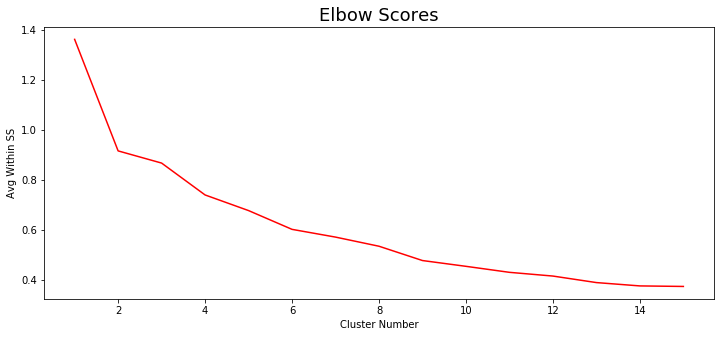

In [89]:
BK_Yelp_sub = BK_Yelp[columns].copy()
BK_Yelp_std = normalize_data(BK_Yelp_sub)

elbow_scores(BK_Yelp_std, 15)

review_cou                      rating                   price  \
             count         mean     sum  count      mean     sum count   
cluster                                                                  
0             1239    65.201776   80785   1239  3.938660  4880.0  1239   
1              771    30.985733   23890    771  2.465629  1901.0   771   
2              243   668.378601  162416    243  3.855967   937.0   243   
3             1022   138.348337  141392   1022  4.192759  4285.0  1022   
4               14  2845.571429   39838     14  4.000000    56.0    14   
5              955   110.205236  105246    955  3.142932  3001.5   955   

                           
              mean    sum  
cluster                    
0        10.000000  12390  
1        10.000000   7710  
2        21.543210   5235  
3        22.255382  22745  
4        24.285714    340  
5        21.910995  20925

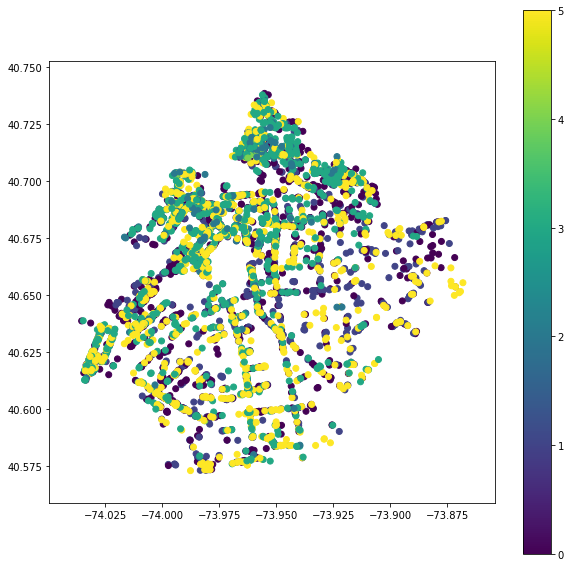

In [90]:
labels = get_kmeans_labels(BK_Yelp_sub, 6)
BK_Yelp['cluster'] = labels

f, ax = plt.subplots(figsize=(10, 10))
BK_Yelp.plot(ax=ax, column='cluster', legend=True)

BK_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

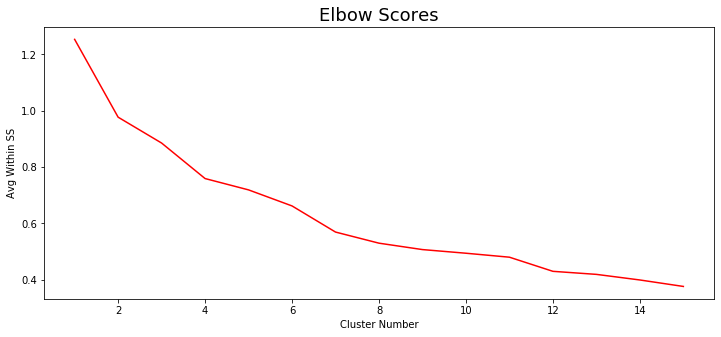

In [91]:
MN_Yelp_sub = MN_Yelp[columns].copy()
MN_Yelp_std = normalize_data(MN_Yelp_sub)

elbow_scores(MN_Yelp_std, 15)

review_cou                       rating                    price  \
             count         mean      sum  count      mean      sum count   
cluster                                                                    
0             2458    96.564280   237355   2458  3.366762   8275.5  2458   
1             4043   259.319812  1048430   4043  3.591022  14518.5  4043   
2              272  2049.665441   557509    272  3.908088   1063.0   272   
3              905   323.697238   292946    905  3.777901   3419.0   905   

                           
              mean    sum  
cluster                    
0        10.000000  24580  
1        20.000000  80860  
2        24.816176   6750  
3        49.530387  44825

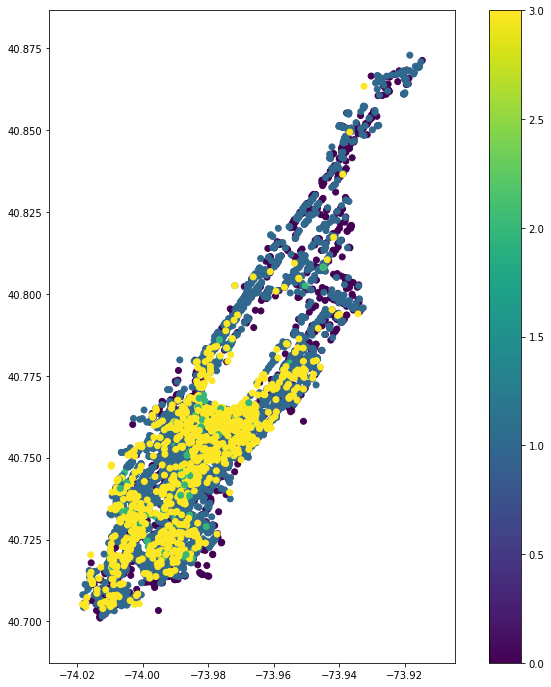

In [92]:
labels = get_kmeans_labels(MN_Yelp_std, 4)
MN_Yelp['cluster'] = labels

f, ax = plt.subplots(1, figsize=(12, 12))
MN_Yelp.plot(ax=ax, column='cluster', legend=True)

MN_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

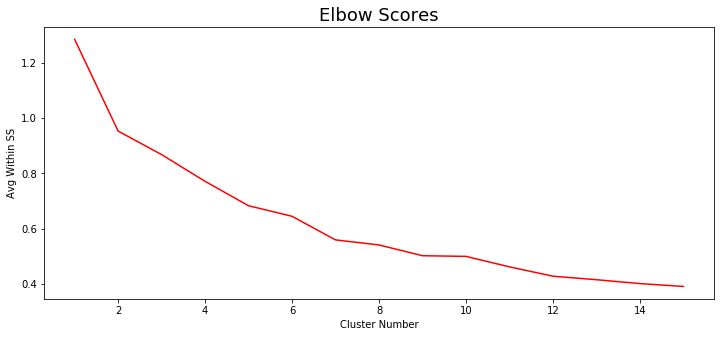

In [93]:
NY_Yelp_sub = NY_Yelp[columns].copy()
NY_Yelp_std = normalize_data(NY_Yelp_sub)

elbow_scores(NY_Yelp_std, 15)

review_cou                      rating                    price  \
             count         mean     sum  count      mean      sum count   
cluster                                                                   
0             2684    91.733234  246212   2684  3.922131  10527.0  2684   
1             4524   216.884615  981186   4524  3.861295  17468.5  4524   
2             2957    59.832939  176926   2957  2.582854   7637.5  2957   
3               48  4150.250000  199212     48  3.979167    191.0    48   
4              746  1156.360590  862645    746  3.852547   2874.0   746   
5              963   232.218069  223626    963  3.778297   3638.5   963   

                           
              mean    sum  
cluster                    
0        10.000000  26840  
1        20.000000  90480  
2        14.149476  41840  
3        26.458333   1270  
4        24.684987  18415  
5        49.340602  47515

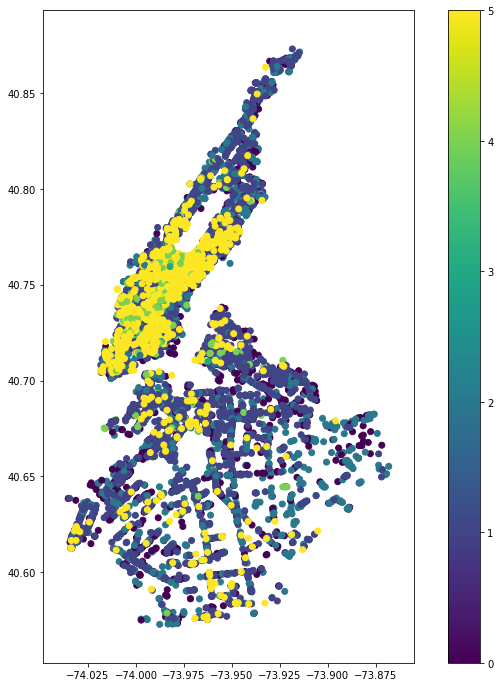

In [79]:
labels = get_kmeans_labels(NY_Yelp_std, 6)
NY_Yelp['cluster'] = labels

f, ax = plt.subplots(1, figsize=(12, 12))
NY_Yelp.plot(ax=ax, column='cluster', legend=True)

NY_Yelp[cols_analysis].groupby(['cluster']).agg(['count','mean','sum'])

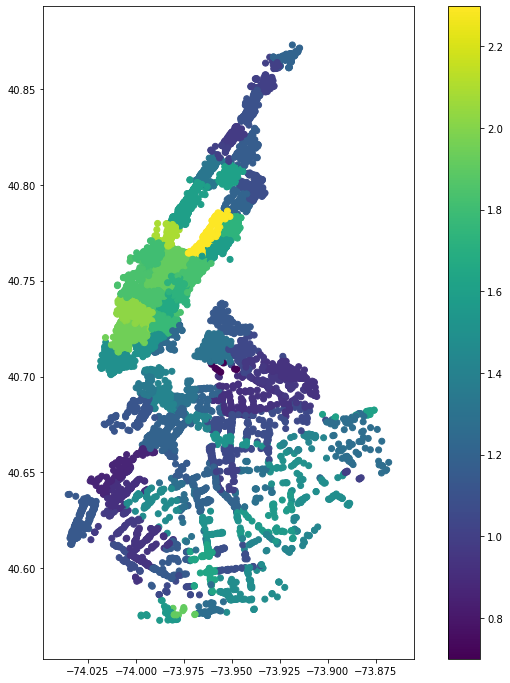

In [80]:
# lET'S ADD THE NTA DATA 
# MN_NTA_Yelp = pd.merge(MN_Yelp, NTA, on='NTACode', how='left')
# BK_NTA_Yelp = pd.merge(BK_Yelp, NTA, on='NTACode', how='left')
# NY_NTA_Yelp = pd.merge(NY_Yelp, NTA, on='NTACode', how='left')

# MN_NTA_Yelp['geometry'] = MN_NTA_Yelp['geometry_y']
# BK_NTA_Yelp['geometry'] = BK_NTA_Yelp['geometry_y']
# NY_NTA_Yelp['geometry'] = NY_NTA_Yelp['geometry_y']


temp = NY_Yelp[['cluster','NTACode']].groupby(['NTACode'], as_index=False).mean()
temp = temp.rename(columns={'cluster': 'avg_cluster'})
temp = pd.merge(NY_Yelp, temp, on='NTACode', how='left')

f, ax = plt.subplots(1, figsize=(12, 12))
temp.plot(ax=ax, column='avg_cluster', legend=True)

NY_NTA_Yelp = pd.merge(temp, NTA, on='NTACode', how='left')
NY_NTA_Yelp['geometry'] = NY_NTA_Yelp['geometry_y']


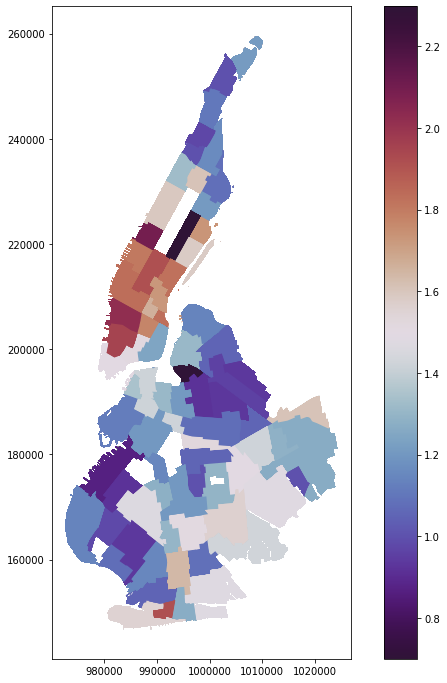

In [83]:
f, ax = plt.subplots(1, figsize=(12, 12))
NY_NTA_Yelp.plot(ax=ax, column='avg_cluster', legend=True, cmap='twilight_shifted')

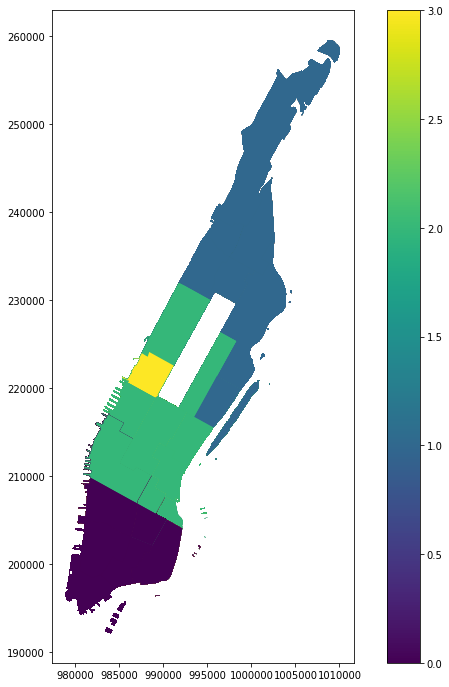

In [450]:
f, ax = plt.subplots(1, figsize=(12, 12))
MN_NTA_Yelp.plot(ax=ax, column='cluster', legend=True)

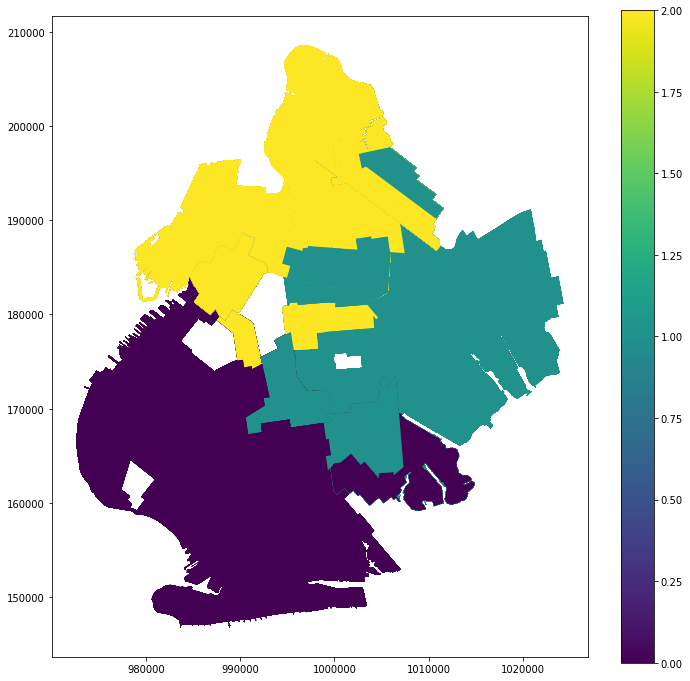

In [451]:
f, ax = plt.subplots(1, figsize=(12, 12))
BK_NTA_Yelp.plot(ax=ax, column='cluster', legend=True)